In [1]:
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_excel("/data/private/pdutta/Wang_collaborator/Survival_vs_death_first_day.xlsx")
df_mean = df.groupby('MouseNo').mean()

In [5]:
df_mean.columns

Index(['Severity', 'Death_0 /Survival_1', 'CD4', 'CD8a', 'CD25', 'IFN-γ',
       'GM-CSF', 'IL-4', 'IL-5', 'IL-6', 'CD18', 'CD28', 'CD62L', 'CD279',
       'IL-1β', 'IL-2', 'IL-9', 'IL-10', 'TNF-α', 'CD69', 'IL-12', 'IL-17A',
       'Perforin', 'CD32', 'CD191', 'CD193', 'VEGF', 'CD11b', 'CD14', 'CD55',
       'CD183', 'CD284', 'TGF-β', 'CD66a', 'CD184', 'CD185', 'CD194', 'CD196',
       'Granzyme B', 'CCL4', 'CD15', 'CD182', 'CD197', 'IL-21', 'HLA-DR',
       'CD181', 'β-Actin', 'IL-22'],
      dtype='object')

In [6]:
X_train = []
Y_train =[]
grouped_df =  df.groupby(['MouseNo'])
for key, item in grouped_df:
    temp_df = grouped_df.get_group(key).reset_index(drop=True).iloc[:,3:].to_numpy()
    #print(temp_df.shape)
    pad_length =  724 - temp_df.shape[0]
    temp_df = np.pad(temp_df, pad_width=((0, pad_length), (0, 0)))
    print(temp_df.shape)
    X_train.append(temp_df)
    Y_train.append(grouped_df.get_group(key).reset_index(drop=True).iloc[0]['Severity'])
print(len(X_train))
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# defining the target
print(Y_train, type(Y_train))

(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
(724, 46)
19
[1. 1. 1. 1. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4.] <class 'numpy.ndarray'>


In [7]:
Y_train.shape

(19,)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)
print(X_train.shape, X_val.shape)

(17, 724, 46) (2, 724, 46)


In [9]:
X_train = X_train.reshape(17, 1, 724, 46)
X_train  = torch.from_numpy(X_train)

# converting the target into torch format
Y_train = Y_train.astype(int)
Y_train = torch.from_numpy(Y_train)

# shape of training data
print(X_train.shape, Y_train.shape)

torch.Size([17, 1, 724, 46]) torch.Size([17])


In [10]:
# converting validation images into torch format
X_val = X_val.reshape(2, 1, 724, 46)
X_val  = torch.from_numpy(X_val)

# converting the target into torch format
Y_val = Y_val.astype(int);
Y_val = torch.from_numpy(Y_val)

# shape of validation data
print(X_val.shape, Y_val.shape)

torch.Size([2, 1, 724, 46]) torch.Size([2])


In [11]:
class ConvNet(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
class ConvNet1(nn.Module):   
    def __init__(self):
        super(ConvNet1, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 90 * 5, 4)
        )

    # Defining the forward pass    
    def forward(self, x):
        #print(x.shape)
        x = self.cnn_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.linear_layers(x)
        #print(x.shape)
        return x

In [13]:
model = ConvNet1().double()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNet1(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1800, out_features=4, bias=True)
  )
)


In [14]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(X_train), Variable(Y_train)
    # print(y_train)
    y_train = y_train - 1
    # getting the validation set
    x_val, y_val = Variable(X_val), Variable(Y_val)
    # converting the data into GPU format
    y_val = y_val - 1
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [15]:
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.0432, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(42.1569, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(10.5938, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(11.5198, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(6.9367, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(5.0515, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(3.6408, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(2.2904, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(1.6099, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : 

In [16]:
train_losses1 = [tensor.item() for tensor in train_losses]
val_losses1 = [tensor.item() for tensor in val_losses]

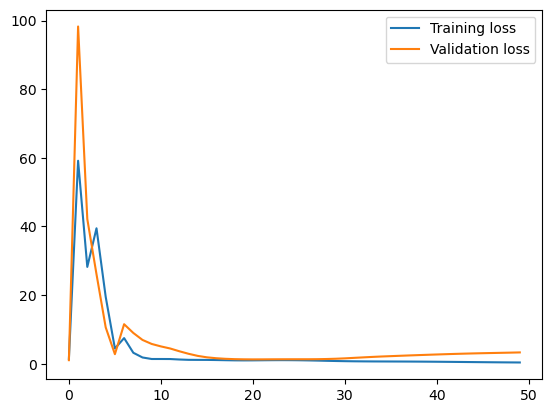

In [17]:
plt.plot(train_losses1, label='Training loss')
plt.plot(val_losses1, label='Validation loss')
plt.legend()
plt.show()

In [18]:
with torch.no_grad():
    output = model(X_train.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
print(prob)
predictions = np.argmax(prob, axis=1)
print("XX")
print(predictions)

# accuracy on training set
accuracy_score(Y_train, predictions)

[array([ 1.64306279,  0.49553452,  2.25727883, 22.15658687]), array([ 0.87844634,  1.58929225,  2.88823423, 11.3431499 ]), array([3.44554015, 1.12161356, 9.20954573, 1.23244263]), array([ 29.58943461, 394.52848588,  39.53103102,   2.05013864]), array([   5.54722789, 1780.61063075,  109.874921  ,    5.76742026]), array([0.98035989, 0.5269808 , 1.04767078, 3.25201298]), array([1.21233353, 0.48498224, 1.59138711, 3.14214888]), array([8.32725032, 0.82937924, 8.6008522 , 5.794541  ]), array([5.01802117e+13, 1.04951428e+07, 4.55787537e+00, 5.01201892e-02]), array([ 3.12162045,  3.01615879, 15.69406812, 59.73009143]), array([  3.54330225, 738.73405397,  35.67231921,   2.29705978]), array([0.85141132, 0.63956031, 5.95918772, 4.37555646]), array([  2.40271078,  19.83337585, 121.47124661,   2.02708166]), array([1.43390691e+06, 5.72526706e+07, 1.19475750e+02, 5.01399963e-01]), array([3.14869980e+02, 5.93695288e+02, 9.58325042e+03, 3.11928763e+00]), array([1.93821091e+07, 2.03975657e+00, 1.6968745

0.0